In [1]:
# for array computations and loading data
import numpy as np

# for building linear regression models and preparing data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# for building and training neural networks
import tensorflow as tf
import matplotlib.pyplot as plt

# custom functions
import utils

# reduce display precision on numpy arrays
#np.set_printoptions(precision=2)

# suppress warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

In [2]:
# Load the dataset from the text file
data = np.loadtxt('./110data.txt', delimiter=',')

# Split the inputs and outputs into separate arrays
x = data[:,0]
y = data[:,1]

# Convert 1-D arrays into 2-D because the commands later will require it
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

print(f"the shape of the inputs x is: {x.shape}")
print(f"the shape of the targets y is: {y.shape}")

the shape of the inputs x is: (104, 1)
the shape of the targets y is: (104, 1)


In [3]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (62, 1)
the shape of the training set (target) is: (62, 1)

the shape of the cross validation set (input) is: (21, 1)
the shape of the cross validation set (target) is: (21, 1)

the shape of the test set (input) is: (21, 1)
the shape of the test set (target) is: (21, 1)


In [ ]:
print(

Minimum value of the training set: 1.00
Maximum value of the training set: 103.00
Scaling factor of the training set: 0.01


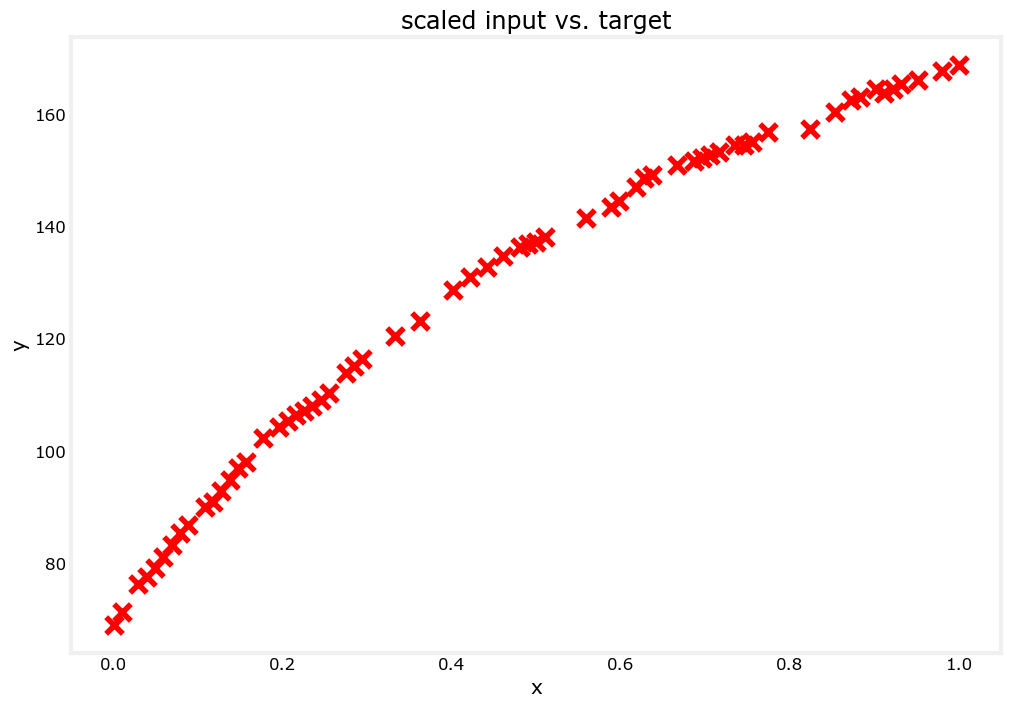

In [4]:
# Initialize the class
#scaler_linear = StandardScaler()
scaler_linear = MinMaxScaler()

# Compute the mean and standard deviation of the training set then transform it
#x_train = x
X_train_scaled = scaler_linear.fit_transform(x_train)

#print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze():.2f}")
#print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():.2f}")

# Corrected code: MinMaxScaler doesn't have squeeze() method
# Instead, we can access data_min_ and data_range_ attributes
print(f"Minimum value of the training set: {scaler_linear.data_min_.squeeze():.2f}")
print(f"Maximum value of the training set: {scaler_linear.data_max_.squeeze():.2f}")
print(f"Scaling factor of the training set: {scaler_linear.scale_.squeeze():.2f}")

#y_train = y
# Plot the results
utils.plot_dataset(x=X_train_scaled, y=y_train, title="scaled input vs. target")

In [5]:
# Add polynomial features
degree = 1
poly = PolynomialFeatures(degree, include_bias=False)

X_train_mapped = poly.fit_transform(x_train)
X_cv_mapped = poly.transform(x_cv)
X_test_mapped = poly.transform(x_test)

# Predict next 6 points
pred_point = 6
data_points = 104
future_x = np.arange(data_points, data_points + pred_point).reshape(-1, 1)  # Predict points 103 to 110
future_x_poly = poly.transform(future_x)

future_x_plot = np.arange(len(future_x))

In [6]:
# Scale the features using the z-score
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train_mapped_scaled = scaler.fit_transform(X_train_mapped)
X_cv_mapped_scaled = scaler.transform(X_cv_mapped)
X_test_mapped_scaled = scaler.transform(X_test_mapped)
future_x_poly_scaled = scaler.transform(future_x_poly)

In [7]:
# Initialize lists that will contain the errors for each model
nn_train_mses = []
nn_cv_mses = []
nn_future_predict = []

# Build the models
tf.random.set_seed(1)
nn_models = utils.build_models_2()

# Loop over the the models
for model in nn_models:
    
    # Setup the loss and optimizer
    model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.065),
    )

    print(f"Training {model.name}...")
    
    # Train the model
    model.fit(
        X_train_mapped_scaled, y_train,
        epochs=300,
        verbose=0
    )
    
    print("Done!\n")

    
    # Record the training MSEs
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    nn_train_mses.append(train_mse)
    
    # Record the cross validation MSEs 
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    nn_cv_mses.append(cv_mse)

    # Record the future predictions 
    yhat = model.predict(future_x_poly_scaled)
    future_y = yhat
    nn_future_predict.append(yhat)
    #print(future_y)
    
# print results
print()
print("RESULTS:")
print()
for model_num in range(len(nn_train_mses)):
    print(
        f"Model {model_num+1}: Training MSE: {nn_train_mses[model_num]:.2f}, " +
        f"CV MSE: {nn_cv_mses[model_num]:.2f}",
        f"\nFuture Predictions:",
        f"\n{nn_future_predict[model_num]}")

Training model_1...
Done!

1/1 [==============================] - 0s 28ms/step
Training model_2...
Done!

1/1 [==============================] - 0s 42ms/step
Training model_3...
Done!

1/1 [==============================] - 0s 31ms/step
Training model_4...
Done!

1/1 [==============================] - 0s 34ms/step

RESULTS:

Model 1: Training MSE: 16.37, CV MSE: 19.43 
Future Predictions: 
[[179.62965]
 [180.57281]
 [181.51596]
 [182.45912]
 [183.40227]
 [184.34543]]
Model 2: Training MSE: 16.48, CV MSE: 19.98 
Future Predictions: 
[[179.12881]
 [180.06926]
 [181.00972]
 [181.95016]
 [182.89061]
 [183.83107]]
Model 3: Training MSE: 16.84, CV MSE: 18.77 
Future Predictions: 
[[181.20737]
 [182.15956]
 [183.11176]
 [184.06398]
 [185.01617]
 [185.96837]]
Model 4: Training MSE: 0.25, CV MSE: 0.26 
Future Predictions: 
[[168.6947 ]
 [169.11081]
 [169.52196]
 [169.92834]
 [170.32999]
 [170.72688]]


In [8]:
# Get the model with the lowest CV MSE (add 1 because list indices start at 0)
model_num = np.argmin(nn_cv_mses) + 1
print(f"Lowest CV MSE values in 4 models are:",
      f"\n {nn_cv_mses}")

Lowest CV MSE values in 4 models are: 
 [19.428621339675477, 19.983704342686288, 18.77497755430873, 0.26072818840893486]


In [9]:
# Get the model with the lowest CV MSE (add 1 because list indices start at 0)
model_num = np.argmin(nn_cv_mses) + 1
min_mse = nn_cv_mses[model_num - 1]  # Get the actual minimum MSE value
print(f"Lowest CV MSE={min_mse:.4f} is found in the model with Model Nr. = {model_num}")

Lowest CV MSE=0.2607 is found in the model with Model Nr. = 4


In [10]:
# Select the model with the lowest CV MSE
#model_num = 4

# Compute the test MSE
yhat = nn_models[model_num-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Selected Model: {model_num}")
print(f"Training MSE: {nn_train_mses[model_num-1]:.2f}")
print(f"Cross Validation MSE: {nn_cv_mses[model_num-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

1/1 [==============================] - 0s 56ms/step
Selected Model: 4
Training MSE: 0.25
Cross Validation MSE: 0.26
Test MSE: 0.50


4/4 [==============================] - 0s 5ms/step
Selected Model: 4
Training MSE: 0.25
Cross Validation MSE: 0.26
Test MSE: 0.3251452408158029
Metrics fit:
	MSE: 0.325145
	R²: 0.999166
Forecasted Values: 
[[168.6947 ]
 [169.11081]
 [169.52196]
 [169.92834]
 [170.32999]
 [170.72688]]


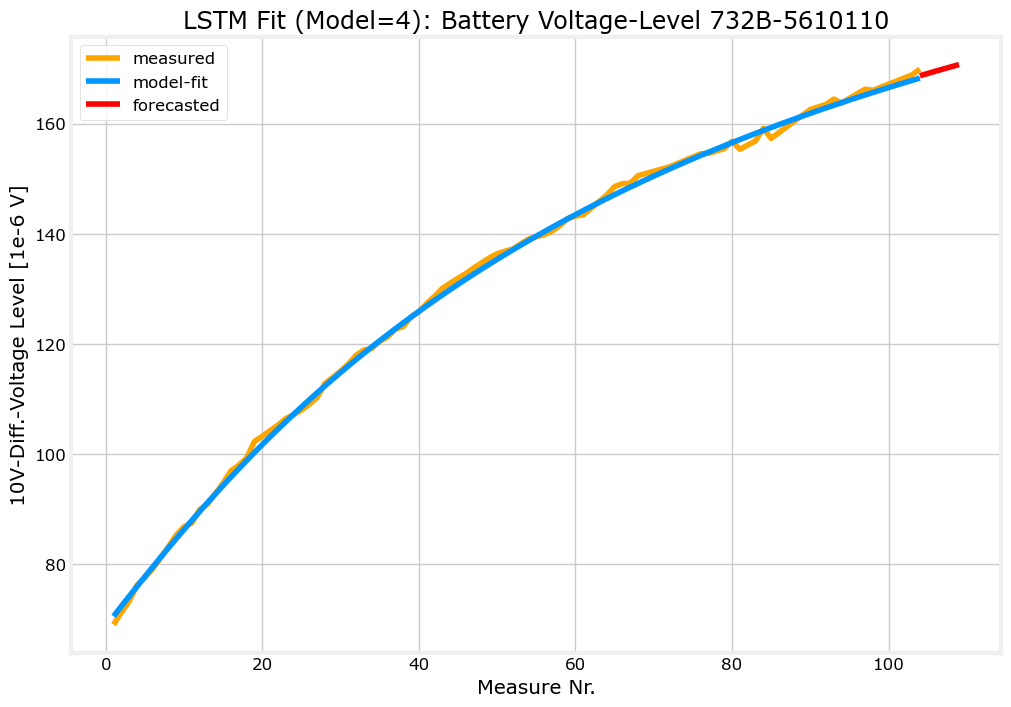

In [11]:
# Compute the test MSE
#X_mapped = polys[degree-1].transform(x)
#X_mapped_scaled = scalers[degree-1].transform(X_mapped)

#yhat = nn_models[model_num-1].predict(X_test_mapped_scaled)
#test_mse = mean_squared_error(y_test, yhat) / 2

X_train_mapped = poly.fit_transform(x)
X_train_mapped_scaled = scaler.fit_transform(X_train_mapped)

yhat_nn = nn_models[model_num-1].predict(X_train_mapped_scaled)
test_mse = mean_squared_error(y, yhat_nn) / 2

print(f"Selected Model: {model_num}")
print(f"Training MSE: {nn_train_mses[model_num-1]:.2f}")
print(f"Cross Validation MSE: {nn_cv_mses[model_num-1]:.2f}")
print(f"Test MSE: {test_mse}")
print(f"Metrics fit:\n\tMSE: {mean_squared_error(y, yhat_nn) / 2:.6f}\n\tR²: {r2_score(y, yhat_nn):.6f}")

print(f"Forecasted Values:",
      f"\n{nn_future_predict[model_num-1]}")

# Plot actual vs predicted
#plt.figure(figsize=(8, 6))
#plt.scatter(y_test, yhat, alpha=0.6, edgecolor='k', label='model-fit')

plt.plot(x, y, color='orange', label='measured')
plt.plot(x, yhat_nn, alpha=1.0, label='model-fit')

#plt.scatter(x_test, y_test, alpha=0.6, label='model-fit')
#plt.scatter(x_train, y_train, alpha=0.6, label='model-fit')

plt.plot(future_x_plot+data_points, nn_future_predict[model_num-1], color='red', label='forecasted')

#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='ideal line')  # Ideal line
#plt.plot(x, yhat_nn, color='red', lw=2, label='model-fit')
#plt.plot(x, y, label='measured')
plt.title(f"LSTM Fit (Model={model_num}): Battery Voltage-Level 732B-5610110")
#plt.xlabel("10V-Diff.-Voltage Level [1e-6 V]")
plt.xlabel("Measure Nr.")
plt.ylabel("10V-Diff.-Voltage Level [1e-6 V]")
plt.legend()
plt.grid(True)
plt.show()


4/4 [==============================] - 0s 6ms/step
Selected Model: 4
Training MSE: 0.25
Cross Validation MSE: 0.26
Test MSE: 0.33
4/4 [==============================] - 0s 5ms/step


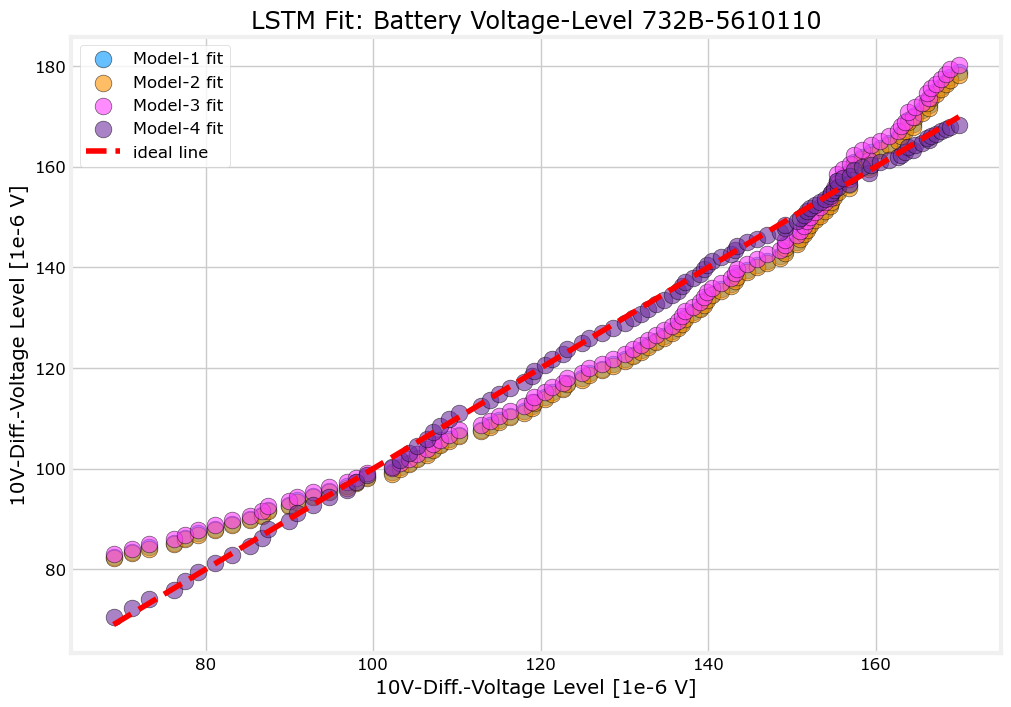

In [13]:
# Predict test set values
#yhat = nn_models[model_num-1].predict(X_test_mapped_scaled)
#test_mse = mean_squared_error(y_test, yhat) / 2
yhat_nn = nn_models[model_num-1].predict(X_train_mapped_scaled)
test_mse = mean_squared_error(y, yhat_nn) / 2

# Compute the test MSE
print(f"Selected Model: {model_num}")
print(f"Training MSE: {nn_train_mses[model_num-1]:.2f}")
print(f"Cross Validation MSE: {nn_cv_mses[model_num-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

# Plot actual vs predicted
# Store predictions from all models in a list
yhat_nn_list = []
for i in range(len(nn_models)):
    yhat_nn_list.append(nn_models[i].predict(X_train_mapped_scaled))
    # Plot the selected model
    # Plot another model for comparison (e.g., model 0)
    # Choose which model to compare with
    plt.scatter(y, yhat_nn_list[i], alpha=0.6, edgecolor='k', label=f'Model-{i+1} fit')


#plt.figure(figsize=(8, 6))
#plt.scatter(y, yhat_nn, alpha=0.6, edgecolor='k', label='model-fit')

# Plot the ideal line - make sure y_test is defined or use y.min() and y.max() instead
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=4, label='ideal line')

plt.title(f"LSTM Fit: Battery Voltage-Level 732B-5610110")
plt.xlabel("10V-Diff.-Voltage Level [1e-6 V]")
plt.ylabel("10V-Diff.-Voltage Level [1e-6 V]")
plt.legend()
plt.grid(True)
plt.show()